In [1]:
%load_ext autoreload
%autoreload 0

In [71]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lib.pandas_util import idxwhere
import sfacts as sf
import numpy as np
import xarray as xr
import seaborn as sns
from scipy.spatial.distance import cdist
import lib.plot

In [91]:
focal_species = '100199'
# mgen_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.nc'
scg_path = f'data/ucfmt.sp-{focal_species}.derep.genotype.nc'
fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts37-s40-g5000-seed0.world.nc'

scg_to_sample_path = f'data/ucfmt.sp-{focal_species}.derep.barcode_to_sample.tsv'
library_to_sample_path = 'data/ucfmt.barcode_to_sample.tsv'
threshold = 0.01
pseudo = 1e-10
scg_cvrg_thresh = 0.05

scg_to_sample = pd.read_table(scg_to_sample_path, names=['scg', 'sample_id'], index_col='scg')
library_to_sample = pd.read_table(library_to_sample_path).rename(columns={'barcode': 'mgen'}).set_index('mgen')

# mgen = sf.data.Metagenotypes.load(mgen_path)
drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)
inference.data['p'] = inference.data['communities'] @ inference.data['genotypes']
inference.data['m'] = inference.metagenotypes.total_counts()

inferred_community = inference.communities
shared_position = list(set(inference.position.values) & set(drplt.position.values))

consensus = inference.metagenotypes.to_estimated_genotypes(pseudo=pseudo).mlift('sel', position=shared_position)
scg = drplt.select_samples_with_coverage(scg_cvrg_thresh).to_estimated_genotypes(pseudo=pseudo).mlift('sel', position=shared_position)
inferred_genotype = inference.genotypes.mlift('sel', position=shared_position)

In [97]:
mgen = inference.metagenotypes
mgen_ss = mgen.random_sample(position=500)

In [98]:
nmf_kwargs = dict(
    alpha=0.0,
    solver="cd",
    tol=1e-3,
    eps=1e-5,
    l1_ratio=1.0,
)
approx = sf.estimation.nmf_approximation(
    mgen_ss.to_world(),
    s=40,
    random_state=0,
    pseudo=1e-10,
    **nmf_kwargs,
)

In [99]:
focal_sample='SS01009'

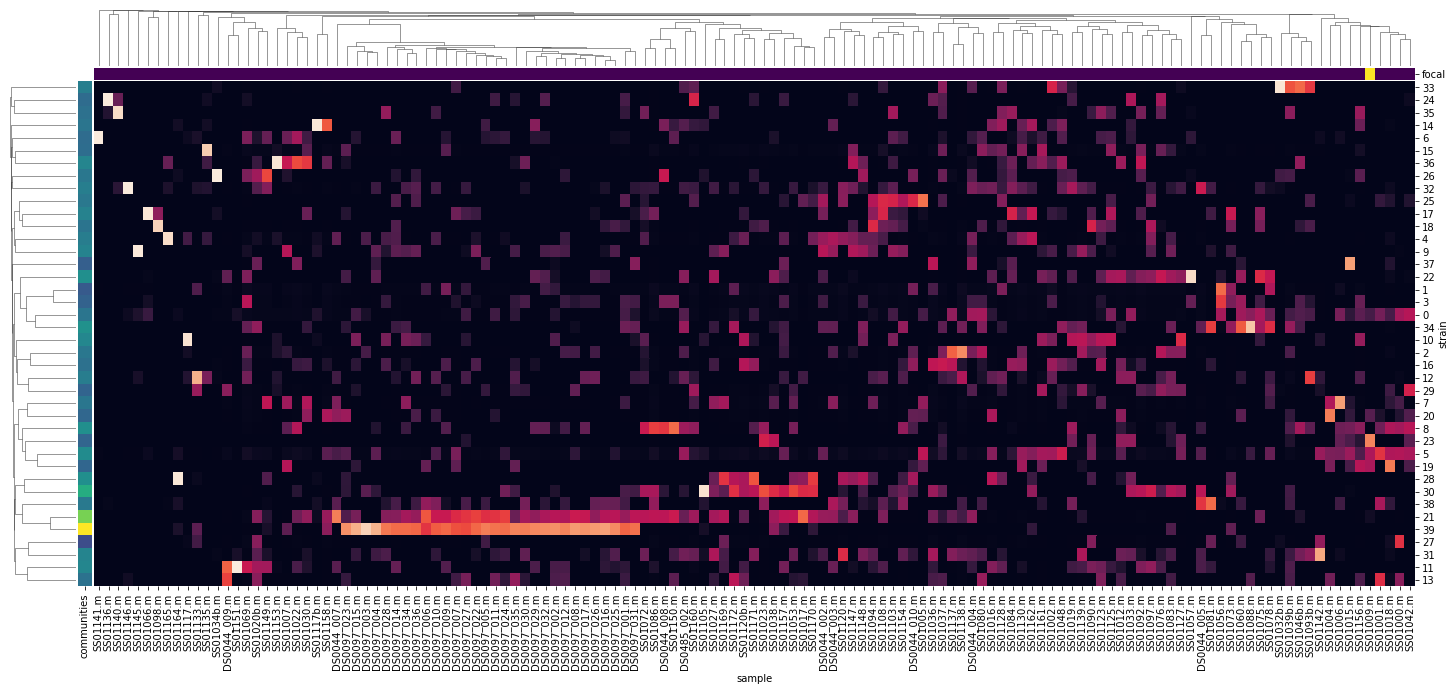

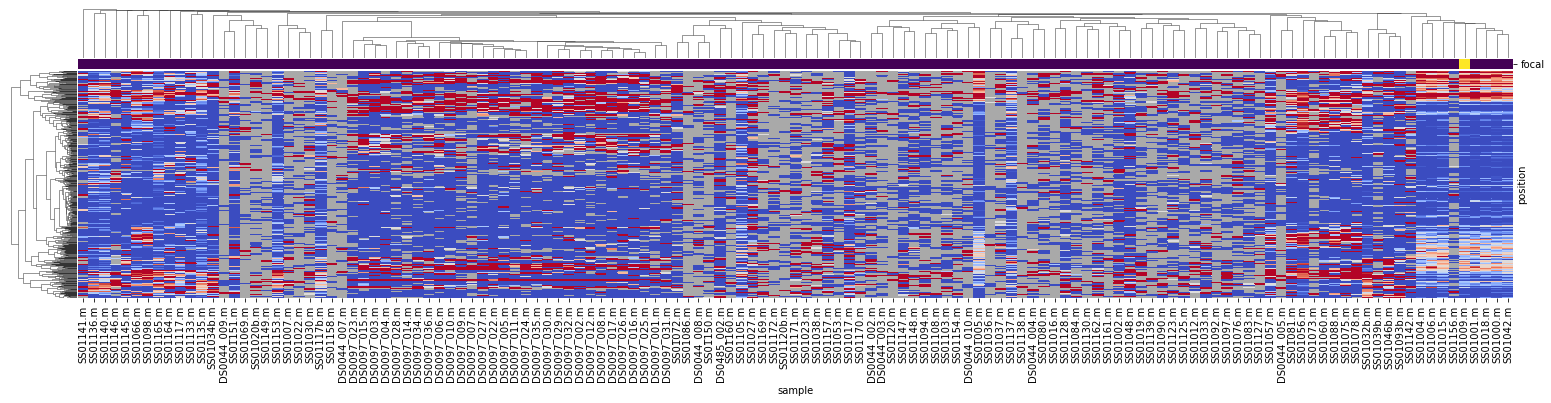

In [101]:
sf.plot_community(
    approx,
    col_linkage_func=lambda w: w.communities.linkage("sample"),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.str.startswith(f'{focal_sample}'),
#         alpha=w.data.alpha,
    )),
)
sf.plot.plot_metagenotype2(
    approx.random_sample(position=500),
    col_linkage_func=lambda w: w.communities.linkage("sample"),
    col_colors_func=lambda w: xr.Dataset(dict(
        focal=w.sample.str.startswith(f'{focal_sample}'),
#         alpha=w.data.alpha,
    )),
)

In [39]:
fit0, *_ = sf.workflow.fit_metagenotypes_complex(
    sf.model_zoo.NAMED_STRUCTURES['ssdd3_with_error'],
    mgen_ss.random_sample(position=51),
    nstrain=40,
    hyperparameters=dict(
        gamma_hyper=1e-3,
        alpha_hyper_mean=200.,
        alpha_hyper_scale=1e-6,
    ),
    anneal_hyperparameters={},
    annealiter=0,
    estimation_kwargs=dict(
        jit=True, catch_keyboard_interrupt=True, ignore_jit_warnings=True, maxiter=int(1e6),
    ),
    device='cpu',
)

[2021-12-10 18:39:55.395764] START: Fitting 40 strains with data shape Frozen({'sample': 109, 'position': 51, 'allele': 2}).
  0%|| 242/1000000 [00:02<2:21:21, 117.87it/s, NLP=+4.630e+10, delta=+2.248e+09, lag20=+3.336e+09, lag100=+4.060e+10, lr=+1.000e-01]
[2021-12-10 18:39:57.459448] Interrupted: NLP=4.21011e+10
[2021-12-10 18:39:57.479058] Finished initial fitting.
[2021-12-10 18:39:57.482060] Average metagenotype error: 0.008290290832519531
[2021-12-10 18:39:57.482454] END: Fit in 2.086074113845825 seconds.


In [8]:
fit1, *_ = sf.workflow.fit_genotypes_conditioned_on_communities_then_collapse(
    sf.model_zoo.NAMED_STRUCTURES['ssdd3_with_error'],
    fit0.metagenotypes,
    fit0.communities,
    hyperparameters=dict(
        gamma_hyper=1.0,
        alpha_hyper_mean=200.,
        alpha_hyper_scale=1e-6,
    ),
    estimation_kwargs=dict(
        jit=True, catch_keyboard_interrupt=True, ignore_jit_warnings=True, maxiter=int(1e6),
    ),
    device='cpu',
    seed=0,
    diss_thresh=0.02,
    frac_thresh=0.001,
)


[2021-12-10 15:44:22.974015] START: Fitting 40 strains to metagenotypes with 51 positions and 109 samples.
  1%|| 6884/1000000 [00:35<1:25:19, 193.98it/s, NLP=+7.303e+03, delta=+4.883e-04, lag20=+0.000e+00, lag100=+4.883e-06, lr=+7.629e-07]
[2021-12-10 15:44:58.467089] Converged: NLP=7.30280e+03
[2021-12-10 15:44:58.484968] Finished model fitting.
[2021-12-10 15:44:58.487751] Average metagenotype error: 0.013602957129478455
[2021-12-10 15:44:58.488140] Collapsing 40 initial strains.
/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts/sfacts/math.py:46: UserWarning: Progress bar not implemented for genotype_pdist.
  warnings.warn("Progress bar not implemented for genotype_pdist.")
[2021-12-10 15:44:58.524362] 28 strains after collapsing.
[2021-12-10 15:44:58.524745] END: Fit in 35.54803013801575 seconds.


In [10]:
fit2, *_ = sf.workflow.iteratively_fit_genotypes_conditioned_on_communities(
    sf.model_zoo.NAMED_STRUCTURES['ssdd3_with_error'],
    fit1.communities,
    mgen_ss,
    nposition=51,
    hyperparameters=dict(
        gamma_hyper=1.0,
        alpha_hyper_mean=200.,
        alpha_hyper_scale=1e-6,
    ),
    estimation_kwargs=dict(
        jit=True, catch_keyboard_interrupt=True, ignore_jit_warnings=True, maxiter=int(1e6),
    ),
    device='cpu',
    seed=0,
)

[2021-12-10 15:45:38.398942] START: Fitting genotypes for 100 positions conditioned on provided communities with 28 strains and 109 samples.
[2021-12-10 15:45:38.401666] Iteratively fitting genotypes by chunks.
[2021-12-10 15:45:38.402179] Fitting bin [0, 51).
  1%|| 6912/1000000 [00:35<1:24:04, 196.85it/s, NLP=+1.225e+04, delta=+0.000e+00, lag20=+4.883e-05, lag100=+9.766e-06, lr=+7.629e-07]
[2021-12-10 15:46:13.517531] Converged: NLP=1.22478e+04
[2021-12-10 15:46:13.535296] Fitting bin [51, 100).
  1%|| 6803/1000000 [00:35<1:25:24, 193.83it/s, NLP=+1.101e+04, delta=+0.000e+00, lag20=+0.000e+00, lag100=+0.000e+00, lr=+7.629e-07]
[2021-12-10 15:46:48.636237] Converged: NLP=1.10064e+04
[2021-12-10 15:46:48.653960] Finished fitting all chunks.
[2021-12-10 15:46:48.656946] END: Fit in 70.25550675392151 seconds.


In [20]:
fit0 = sf.data.World.load('data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05-g200.fit-sfacts36-s10-g101-seed0.world_initial.nc')
fit1 = sf.data.World.load('data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05-g200.fit-sfacts36-s10-g101-seed0.world_collapsed.nc')
fit2 = sf.data.World.load('data/ucfmt.sp-104345.metagenotype.filt-poly05-cvrg05-g200.fit-sfacts36-s10-g101-seed0.world.nc')

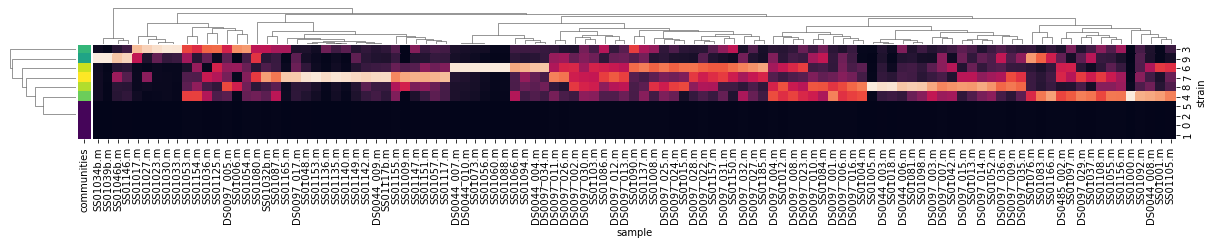

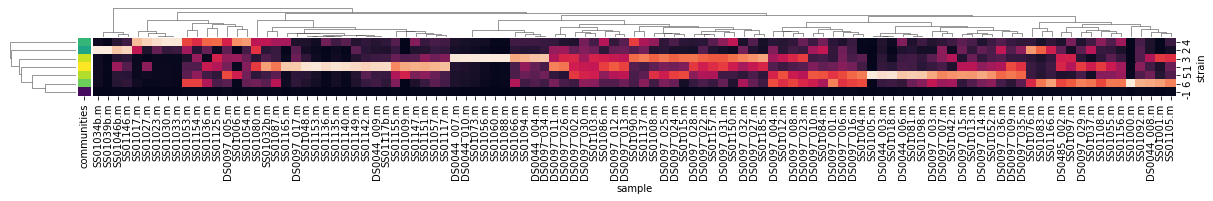

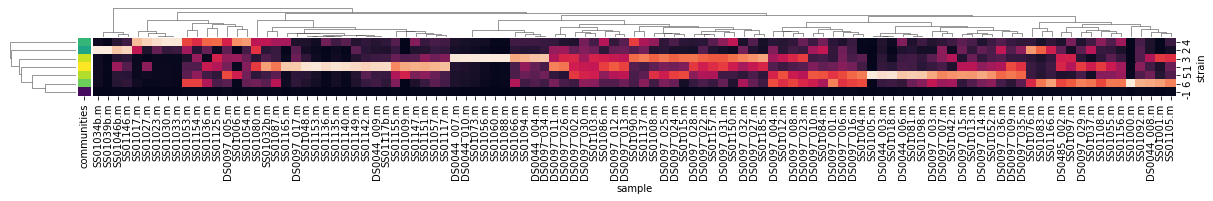

In [26]:
sf.plot.plot_community(fit0)
sf.plot.plot_community(fit1)
sf.plot.plot_community(fit2)

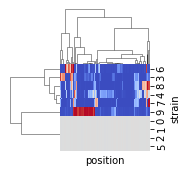

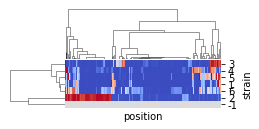

In [28]:
sf.plot.plot_genotype(fit0)
sf.plot.plot_genotype(fit2)

In [104]:
focal_species = '100022'
fit_path = f'data/ucfmt.sp-{focal_species}.metagenotype.filt-poly05-cvrg05.fit-sfacts36-s40-g5000-seed0.world.nc'

library_to_sample_path = 'data/ucfmt.barcode_to_sample.tsv'
threshold = 0.01
pseudo = 1e-10
scg_cvrg_thresh = 0.05

library_to_sample = pd.read_table(library_to_sample_path).rename(columns={'barcode': 'mgen'}).set_index('mgen')

drplt = sf.data.Metagenotypes.load(scg_path)
inference = sf.data.World.load(fit_path)
inference.data['p'] = inference.data['communities'] @ inference.data['genotypes']
inference.data['m'] = inference.metagenotypes.total_counts()

inferred_community = inference.communities
shared_position = list(set(inference.position.values))

consensus = inference.metagenotypes.to_estimated_genotypes(pseudo=pseudo).mlift('sel', position=shared_position)
inferred_genotype = inference.genotypes.mlift('sel', position=shared_position)

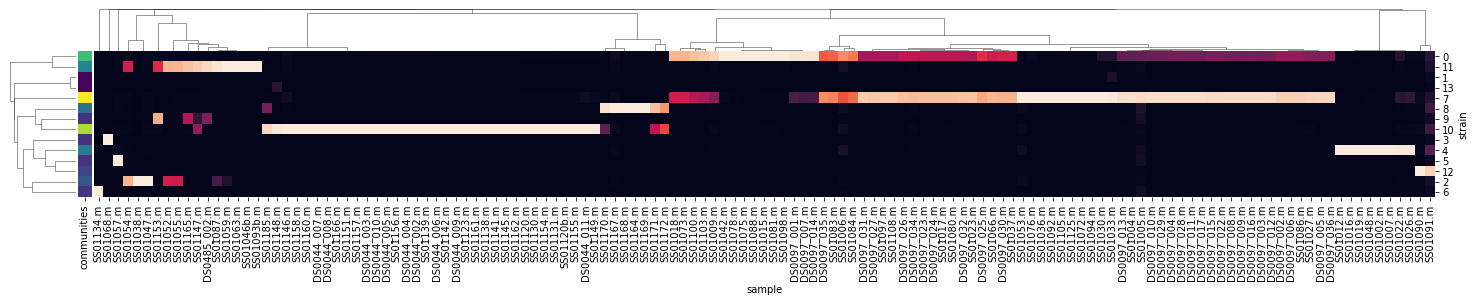

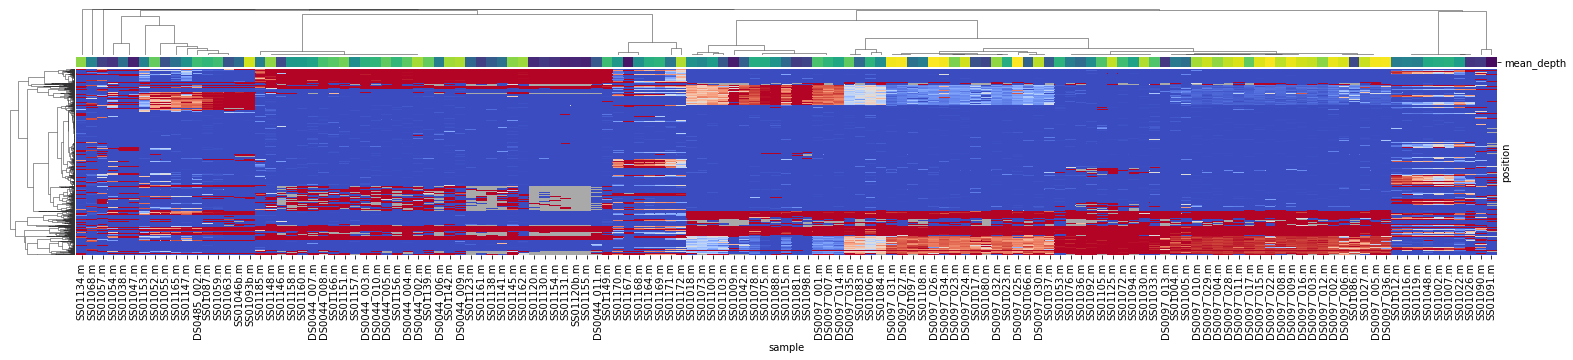

In [113]:
sf.plot.plot_community(inference, row_linkage_func=lambda w: w.genotypes.linkage("strain"))
sf.plot.plot_metagenotype2(inference, col_linkage_func=lambda w: w.communities.linkage("sample"), scaley=1e-3)